# Tract🩻Segm: Statistic ⚖️ predictions

This is a simple statistical kernel, where we assume that all bodies are approximately aligned...

Then we reconstruct all annotations in their 3D form and scale them to an average shape, and accumulate label appearance per each class.

Later, when we are asked for a prediction, we take an average segmentation, thresholding over a given level of presence.

As an extension, we can accumulate these stats over time, so  each day will have its own accumulation and we can use linear extrapolation if needed.

In [1]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt

DATASET_FOLDER = "/home/jirka/Datasets/uw-madison-gi-tract-image-segmentation"

In [2]:
df_train = pd.read_csv(os.path.join(DATASET_FOLDER, "train.csv"))
print(f"size: {len(df_train)}")
display(df_train.head(3))

df_ssub = pd.read_csv(os.path.join(DATASET_FOLDER, "sample_submission.csv"))
print(f"size: {len(df_ssub)}")
display(df_ssub.head(3))

size: 115488


,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN


size: 0


,id,class,predicted


In [3]:
def enrich_data(df, sdir="train"):
    imgs = glob.glob(os.path.join(DATASET_FOLDER, sdir, "case*", "case*_day*", "scans", "*.png"))
    img_folders = [os.path.dirname(p).split(os.path.sep) for p in imgs]
    img_names = [os.path.splitext(os.path.basename(p))[0].split("_") for p in imgs]
    img_keys = [f"{f[-2]}_slice_{n[1]}" for f, n in zip(img_folders, img_names)]

    print(img_keys[:5])
    df["img_path"] = df["id"].map({k: p for k, p in zip(img_keys, imgs)})
    df["Case_Day"] = df["id"].map({k: f[-2] for k, f in zip(img_keys, img_folders)})
    df["Case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
    df["Day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
    df["Slice"] = df["id"].map({k: int(n[1]) for k, n in zip(img_keys, img_names)})
    df["width"] = df["id"].map({k: int(n[2]) for k, n in zip(img_keys, img_names)})
    df["height"] = df["id"].map({k: int(n[3]) for k, n in zip(img_keys, img_names)})
    df["spacing1"] = df["id"].map({k: float(n[4]) for k, n in zip(img_keys, img_names)})
    df["spacing2"] = df["id"].map({k: float(n[5]) for k, n in zip(img_keys, img_names)})

In [4]:
enrich_data(df_train, "train")
display(df_train.head())

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
df_train.drop_duplicates("Case_Day")[["height", "width"]].value_counts().plot.bar(ax=axes[0], grid=True)
df_train.drop_duplicates("Case_Day")[["spacing1", "spacing2"]].value_counts().plot.bar(ax=axes[1], grid=True)
df_train[df_train["class"] == "stomach"].groupby("Case_Day").size().value_counts().plot.pie(ax=axes[2])

['case18_day25_slice_0032', 'case18_day25_slice_0001', 'case18_day25_slice_0099', 'case18_day25_slice_0061', 'case18_day25_slice_0023']


,id,class,segmentation,img_path,Case_Day,Case,Day,Slice,width,height,spacing1,spacing2
0,case123_day20_slice_0001,large_bowel,NaN,/home/jirka/Datasets/uw-madison-gi-tract-image...,case123_day20,123,20,1,266,266,1.5,1.5
1,case123_day20_slice_0001,small_bowel,NaN,/home/jirka/Datasets/uw-madison-gi-tract-image...,case123_day20,123,20,1,266,266,1.5,1.5
2,case123_day20_slice_0001,stomach,NaN,/home/jirka/Datasets/uw-madison-gi-tract-image...,case123_day20,123,20,1,266,266,1.5,1.5
3,case123_day20_slice_0002,large_bowel,NaN,/home/jirka/Datasets/uw-madison-gi-tract-image...,case123_day20,123,20,2,266,266,1.5,1.5
4,case123_day20_slice_0002,small_bowel,NaN,/home/jirka/Datasets/uw-madison-gi-tract-image...,case123_day20,123,20,2,266,266,1.5,1.5


<AxesSubplot:ylabel='None'>

In [5]:
enrich_data(df_ssub, "test")
display(df_ssub.head())

[]


,id,class,predicted,img_path,Case_Day,Case,Day,Slice,width,height,spacing1,spacing2


## Aggregate cumulative map

In [6]:
import numpy as np

def rle_decode(rle, img = None, label = 1):
    seq = rle.split()
    starts = np.array(list(map(int, seq[0::2])))
    lengths = np.array(list(map(int, seq[1::2])))
    ends = starts + lengths
    img_shape = img.shape
    img = img.flatten()
    for begin, end in zip(starts, ends):
        img[begin:end] = label
    return img.reshape(img_shape)

In [7]:
import torch.nn.functional as F

def interpolate_volume(volume, vol_size):
    vol_shape = tuple(volume.shape)
    if not vol_size:
        d_new = min(vol_shape[:2])
        vol_size = (vol_shape[0], vol_shape[1], d_new)
    # assert vol_shape[0] == vol_shape[1], f"mixed shape: {vol_shape}"
    if vol_shape == vol_size:
        return volume
    vol = F.interpolate(volume.unsqueeze(0).unsqueeze(0), size=vol_size, mode="nearest")
    return vol[0, 0]

In [8]:
import torch
import numpy as np
from tqdm.auto import tqdm

AVG_VOLUME_SIZE = (144, 266, 266)
segms, counts = {}, {}

for lb, dfg in df_train.groupby("class"):
    print(lb)
    vol_acc, nb_acc = {}, {}
    for cd, dfgg in tqdm(dfg.groupby("Case_Day")):
        day = dfgg["Day"].iloc[0]
        h, w = dfgg[["height", "width"]].iloc[0]
        vol = np.zeros((len(dfgg), h, w))
        for _, row in dfgg.iterrows():
            idx = int(row['Slice']) - 1
            rle = row["segmentation"]
            if not rle or not isinstance(rle, str):
                continue
            vol[idx, :, :] = rle_decode(rle, img=vol[idx, :, :], label=1)
        vol = interpolate_volume(torch.tensor(vol), vol_size=AVG_VOLUME_SIZE).numpy()
        vol_acc[day] = vol_acc.get(day, np.zeros(AVG_VOLUME_SIZE, dtype=np.uint16)) + vol
        nb_acc[day] = nb_acc.get(day, 0) + 1
    for d in vol_acc:
        vol_acc[d] = vol_acc[d] / float(nb_acc[d])
    segms[lb] = vol_acc
    counts[lb] = nb_acc

large_bowel


  0%|          | 0/274 [00:00<?, ?it/s]

small_bowel


  0%|          | 0/274 [00:00<?, ?it/s]

stomach


  0%|          | 0/274 [00:00<?, ?it/s]

In [9]:
days = sorted(segms["stomach"].keys())
print(days)

[0, 1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 34, 35, 36, 38, 39]


In [10]:
from ipywidgets import interact, IntSlider

def show_volumes(segms, counts, z, y, x, day=10, fig_size=(12, 12)):
    day = sorted(segms["stomach"])[day]
    fig, axarr = plt.subplots(nrows=3, ncols=3, figsize=fig_size)
    for i, lb in enumerate(segms):
        for j in range(3):
            axarr[i, j].set_title(f"{lb};\n day:{day} with cases:{counts[lb][day]}\n sum over axis {j}")
            im = axarr[i, j].imshow(np.sum(segms[lb][day], axis=j) / segms[lb][day].shape[j])
            fig.colorbar(im, ax= axarr[i, j])

def interactive_show_cum(segms, counts):
    interact(
        lambda z, y, x, day: plt.show(show_volumes(segms, counts, z, y, x, day)),
        z=IntSlider(min=0, max=AVG_VOLUME_SIZE[0], step=5, value=int(AVG_VOLUME_SIZE[0] / 2)),
        y=IntSlider(min=0, max=AVG_VOLUME_SIZE[1], step=5, value=int(AVG_VOLUME_SIZE[1] / 2)),
        x=IntSlider(min=0, max=AVG_VOLUME_SIZE[2], step=5, value=int(AVG_VOLUME_SIZE[2] / 2)),
        day=IntSlider(min=0, max=len(days), step=1, value=0),
    )

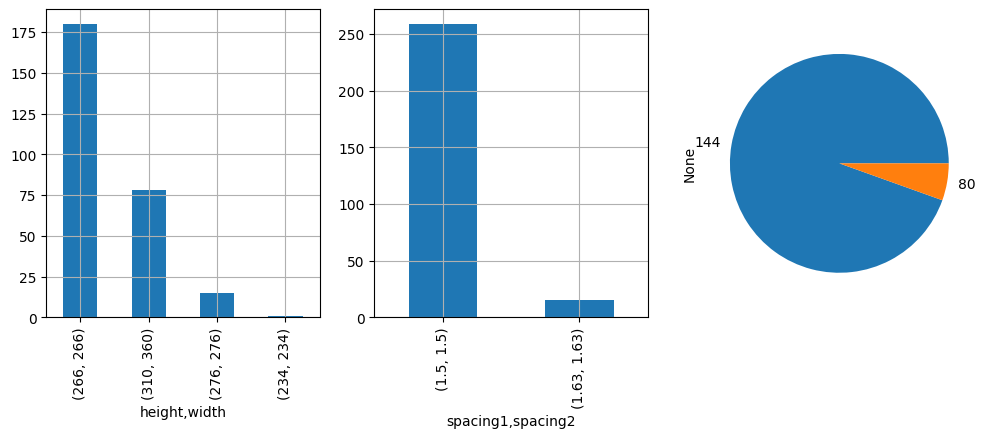

interactive(children=(IntSlider(value=72, description='z', max=144, step=5), IntSlider(value=133, description=…

In [11]:
interactive_show_cum(segms, counts)

In [12]:
from ipywidgets import interact, IntSlider, FloatSlider

LABELS = sorted(df_train['class'].unique())

def show_volume(segms, z, y, x, day=0, thr=0.05, fig_size=(14, 14)):
    day = sorted(segms["stomach"])[day]
    fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
    
    segms_lb = [np.ones(AVG_VOLUME_SIZE) * thr]
    segms_lb += [segms[lb][day] for lb in LABELS]
    segm = np.argmax(segms_lb, axis=0)
    #print(segm.shape)
    
    _imshow_args = dict(cmap="jet", interpolation="antialiased", interpolation_stage="rgb", vmin=0, vmax=len(segms))
    axarr[0, 0].imshow(segm[z, :, :], **_imshow_args)
    axarr[0, 1].set_title(f"day:{day} with cases:{counts[lb][day]}")
    axarr[0, 1].imshow(segm[:, :, x], **_imshow_args)
    axarr[1, 0].set_title(f"day:{day} with cases:{counts[lb][day]}")
    axarr[1, 0].imshow(segm[:, y, :], **_imshow_args)
    axarr[1, 1].set_axis_off()
    fig.tight_layout()


def interactive_show_segm(segms):
    interact(
        lambda z, y, x, day, thr: plt.show(show_volume(segms, z, y, x, day, thr)),
        z=IntSlider(min=0, max=AVG_VOLUME_SIZE[0], step=5, value=int(AVG_VOLUME_SIZE[0] / 2)),
        y=IntSlider(min=0, max=AVG_VOLUME_SIZE[1], step=5, value=int(AVG_VOLUME_SIZE[1] / 2)),
        x=IntSlider(min=0, max=AVG_VOLUME_SIZE[2], step=5, value=int(AVG_VOLUME_SIZE[2] / 2)),
        day=IntSlider(min=0, max=len(days), step=1, value=0),
        thr=FloatSlider(min=0, max=1, step=0.05, value=0.1),
    )

In [13]:
interactive_show_segm(segms)

interactive(children=(IntSlider(value=72, description='z', max=144, step=5), IntSlider(value=133, description=…

## Extrapolate 🔎 predictions

In [14]:
def rle_encode(mask, bg = 0) -> dict:
    vec = mask.flatten()
    nb = len(vec)
    where = np.flatnonzero
    starts = np.r_[0, where(~np.isclose(vec[1:], vec[:-1], equal_nan=True)) + 1]
    lengths = np.diff(np.r_[starts, nb])
    values = vec[starts]
    assert len(starts) == len(lengths) == len(values)
    rle = {}
    for start, length, val in zip(starts, lengths, values):
        if val == bg:
            continue
        rle[val] = rle.get(val, []) + [str(start), length]
    # post-processing
    rle = {lb: " ".join(map(str, id_lens)) for lb, id_lens in rle.items()}
    return rle

In [15]:
# def _process_slice(row, vol, lb):
#     idx = int(row['Slice']) - 1
#     mask = vol[idx, :, :]
#     rle = rle_encode(mask)[1] if np.sum(mask) > 1 else None
#     return {"id": row["id"], "class": lb, "predicted": rle}


def _interpolate_day(segm_lb, day):
    if day in segm_lb:
        return segm_lb[day]
    days_last = [d for d in segm_lb.keys() if d < day]
    day_last = max(days_last)
    days_next = [d for d in segm_lb.keys() if d > day]
    if not days_next:
        return segm_lb[day_last]
    day_next = min(days_next)
    dn = (day - day_last) / (day_next - day_last)
    dl = (day_next - day) / (day_next - day_last)
    return dl * segm_lb[day_last] + dn * segm_lb[day_next]


def _process_vol(dfgg, segm, thr, lb):
    day = int(dfgg[["Day"]].iloc[0])
    h, w = dfgg[["height", "width"]].iloc[0]
    vol = interpolate_volume(
        torch.tensor(_interpolate_day(segm, day) > thr, dtype=float),
        vol_size=(len(dfgg), h, w),
    ).numpy().astype(np.uint8)
    rows = []
    for _, row in dfgg.iterrows():
        idx = int(row['Slice']) - 1
        mask = vol[idx, :, :]
        rle = rle_encode(mask)[1] if np.sum(mask) > 1 else ""
        rows.append({"id": row["id"], "class": lb, "predicted": rle})
    return rows

In [16]:
segm_thr = 0.03
df_pred = df_train if df_ssub.empty else df_ssub

preds = []
for _, dfg in tqdm(df_pred.groupby("Case_Day")):
    day = int(dfg[["Day"]].iloc[0])
    segms_lb = [np.ones(AVG_VOLUME_SIZE) * segm_thr]
    segms_lb += [_interpolate_day(segms[lb], day) for lb in LABELS]
    segm_sc = np.argmax(segms_lb, axis=0)
    h, w = dfg[["height", "width"]].iloc[0]
    dfgg = dfg[dfg["class"] == LABELS[0]]
    vol = interpolate_volume(torch.tensor(segm_sc, dtype=float), vol_size=(len(dfgg), h, w)).numpy().astype(np.uint8)
    for _, row in dfgg.iterrows():
        idx = int(row['Slice']) - 1
        mask = vol[idx, :, :]
        rle = rle_encode(mask) if np.sum(mask) > 1 else {}
        preds += [{"id": row["id"], "class": lb, "predicted": rle.get(i + 1, "")} for i, lb in enumerate(LABELS)]


df_pred = pd.DataFrame(preds)
display(df_pred[df_pred['predicted'] != ""])

  0%|          | 0/274 [00:00<?, ?it/s]

,id,class,predicted
92,case101_day20_slice_0031,stomach,27529 5 27794 8 28060 9 28325 11 28591 12 2885...
95,case101_day20_slice_0032,stomach,26732 6 26997 8 27263 8 27527 12 27792 13 2805...
98,case101_day20_slice_0033,stomach,26466 7 26731 8 26996 10 27261 12 27526 14 277...
101,case101_day20_slice_0034,stomach,25669 5 25932 12 26197 13 26462 15 26727 17 26...
104,case101_day20_slice_0035,stomach,25667 6 25930 13 26195 15 26460 17 26726 17 26...
...,...,...,...
115423,case9_day22_slice_0123,small_bowel,19974 13 20331 20 20691 20 21050 25 21408 29 2...
115425,case9_day22_slice_0124,large_bowel,35026 1 35030 4 35383 15 35743 15 36101 21 364...
115426,case9_day22_slice_0124,small_bowel,19975 8 20332 17 20692 17 21050 23 21408 27 21...
115428,case9_day22_slice_0125,large_bowel,35031 2 35383 14 35743 14 36101 20 36459 25 36...


## Prepare 🗄️ submission

In [17]:
del df_ssub['predicted']
df_pred = df_ssub.merge(df_pred, on=['id','class'])

df_pred[['id', 'class', 'predicted']].to_csv("submission.csv", index=False)

!head submission.csv

id,class,predicted
